### Choosing the Cohort:
The first step is about picking the right group of customers for our analysis. To do this, we're looking at customers who've interacted with our platform after New Year's Day in 2023 (starting from January 4th). We're particularly interested in those who've actively used our platform more than seven times during this period.

This approach helps us focus on a set of customers who've been engaged with our platform for a while and have shown consistent interaction. It gives us a substantial amount of data to study, rather than including customers who might have just started using our platform recently.

Here is the SQL code to bring in all the data.

In [1]:
# Import necessary libraries for data analysis and visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import warnings
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame


In [2]:
data = pd.read_csv("cohort.csv")

In [3]:
data.T

0      \
session_id               489575-c499fadc9eb7453dbba3b81408d9cecc   
user_id                                                   489575   
trip_id                  489575-5101ffae97ed4ae49b0b35bb2f84e964   
session_start                                2022-12-25 10:01:00   
session_end                                  2022-12-25 10:03:54   
flight_discount                                            False   
hotel_discount                                             False   
flight_discount_amount                                       NaN   
hotel_discount_amount                                        NaN   
flight_booked                                               True   
hotel_booked                                                True   
page_clicks                                                   24   
cancellation                                               False   
trip_id.1                489575-5101ffae97ed4ae49b0b35bb2f84e964   
origin_airport                                               YHM   
destination                                              chicago   
destination_airport                                          MDW   
seats                                                        1.0   
return_flight_booked                                        True   
departure_time                               2022-12-29 12:00:00   
return_time                                  2023-01-04 12:00:00   
checked_bags                                                 1.0   
trip_airline                                  Southwest Airlines   
destination_airport_lat                                   41.786   
destination_airport_lon                                  -87.752   
base_fare_usd                                             124.09   
trip_id.2                489575-5101ffae97ed4ae49b0b35bb2f84e964   
hotel_name                                   Marriott  - chicago   
nights                                                       3.0   
rooms                                                        1.0   
check_in_time                             2022-12-29 14:49:25.86   
check_out_time                               2023-01-02 11:00:00   
hotel_per_room_usd                                         128.0   
user_id.1                                                 489575   
birthdate                                             1979-02-02   
gender                                                         F   
married                                                     True   
has_children                                                True   
home_country                                              canada   
home_city                                               hamilton   
home_airport                                                 YHM   
home_airport_lat                                          43.173   
home_airport_lon                                         -79.935   
sign_up_date                                          2022-12-25   

                                                           1      \
session_id               651613-9455e0b3819c4673a4a5959799f7cfc3   
user_id                                                   651613   
trip_id                  651613-feaf39596bde4c788c8ff9f11b3071c2   
session_start                                2023-03-27 22:55:00   
session_end                                  2023-03-27 22:57:12   
flight_discount                                             True   
hotel_discount                                             False   
flight_discount_amount                                       0.2   
hotel_discount_amount                                        NaN   
flight_booked                                               True   
hotel_booked                                                True   
page_clicks                                                   18   
cancellation                                               False   
trip_id.1                651613-feaf39596bde4c

In [4]:
data["return_time"] , data["departure_time"]

# Assuming data is a DataFrame with columns 'return_time' and 'departure_time'
data["return_time"] = pd.to_datetime(data["return_time"])
data["departure_time"] = pd.to_datetime(data["departure_time"])

# Calculate the time difference in minutes
data["trip_duration"] = (data["return_time"] - data["departure_time"]).dt.total_seconds() / 60
data["trip_duration"]



0        8640.0
1        2880.0
2           NaN
3        1440.0
4        5760.0
          ...  
49995    5760.0
49996    4320.0
49997    5760.0
49998    4320.0
49999    4320.0
Name: trip_duration, Length: 50000, dtype: float64

In [5]:
data["session_start"] = pd.to_datetime(data["session_start"])


data['last_minute_booking'] = (data['departure_time'] - data['session_start']).dt.total_seconds() / 60
data['last_minute_booking']

0         5879.0
1        13445.0
2            NaN
3        15669.0
4         7877.0
          ...   
49995    18197.0
49996    16195.0
49997     9551.0
49998    12281.0
49999    11656.0
Name: last_minute_booking, Length: 50000, dtype: float64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   session_id               50000 non-null  object        
 1   user_id                  50000 non-null  int64         
 2   trip_id                  16918 non-null  object        
 3   session_start            50000 non-null  datetime64[ns]
 4   session_end              50000 non-null  object        
 5   flight_discount          50000 non-null  bool          
 6   hotel_discount           50000 non-null  bool          
 7   flight_discount_amount   8421 non-null   float64       
 8   hotel_discount_amount    6312 non-null   float64       
 9   flight_booked            50000 non-null  bool          
 10  hotel_booked             50000 non-null  bool          
 11  page_clicks              50000 non-null  int64         
 12  cancellation             50000 n

In [7]:
# calculates the number of sessions for each user

grouped_session = data.groupby('user_id')['session_id'].size().reset_index()

grouped_session.rename(columns={'session_id': 'num_sessions'}, inplace=True)

data = data.merge(grouped_session, on='user_id', how='left', suffixes=('_clean', '_grouped'))

data["num_sessions"]

0         9
1        10
2         9
3         8
4         9
         ..
49995     8
49996     8
49997     8
49998     9
49999     8
Name: num_sessions, Length: 50000, dtype: int64

In [8]:
data["session_start"] = pd.to_datetime(data["session_start"], format = "mixed", errors = "coerce")
data["session_end"] = pd.to_datetime(data["session_end"], format = "mixed", errors = "coerce")

data["session_length"] = data["session_end"] - data["session_start"]

data["session_length"] = data["session_length"].dt.total_seconds() / 60
data["session_length"]

0        2.900000
1        2.200000
2        1.283333
3        1.966667
4        2.550000
           ...   
49995    3.983333
49996    2.450000
49997    2.766667
49998    4.100000
49999    2.966667
Name: session_length, Length: 50000, dtype: float64

In [9]:
data['check_in_time'] = pd.to_datetime(data['check_in_time'], format = "mixed", errors = "coerce")

data["avg_booking_departure_gap_days_hotels"] = data['check_in_time'] - data["session_start"] 
data["avg_booking_departure_gap_days_hotels"] = data["avg_booking_departure_gap_days_hotels"].dt.total_seconds() / 60

In [10]:
data["avg_booking_departure_gap_days_hotels"]

0         6048.43100
1        13625.55575
2         2223.00000
3                NaN
4         8167.85600
            ...     
49995    18565.31825
49996    16555.30600
49997     9809.94050
49998    12660.29525
49999    11908.47775
Name: avg_booking_departure_gap_days_hotels, Length: 50000, dtype: float64

In [11]:
# Calculate the total number of flights
total_flights = len(data)

# Calculate the number of flights with a discount
discounted_flights = len(data[data['flight_discount_amount'] > 0])

# Calculate the discount flight proportion
data['discount_flight_proportion'] = discounted_flights / total_flights




In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   session_id                             50000 non-null  object        
 1   user_id                                50000 non-null  int64         
 2   trip_id                                16918 non-null  object        
 3   session_start                          50000 non-null  datetime64[ns]
 4   session_end                            50000 non-null  datetime64[ns]
 5   flight_discount                        50000 non-null  bool          
 6   hotel_discount                         50000 non-null  bool          
 7   flight_discount_amount                 8421 non-null   float64       
 8   hotel_discount_amount                  6312 non-null   float64       
 9   flight_booked                          50000 non-null  bool  

In [13]:
#conversion rate, dividing the number of booked trips (in case of no cancellation) by total number of browising sessions

booked_trips = data[(data["flight_booked"] == True) & (data["cancellation"] == False)]
num_booked_trip = len( booked_trips)

total_sessions = len(data)

data["conversion_rate"] = num_booked_trip / total_sessions


In [14]:
data_df = pd.DataFrame(data)


In [15]:
# The columns "trip_id.1," "trip_id.2," and "user_id.1" are redundant duplicates and have been removed from the DataFrame "data_df" to avoid unnecessary duplication.
data_df = data_df.drop(columns = ["trip_id.1", "trip_id.2", "user_id.1"], axis = 1)


In [70]:
# The function haversine calculates the distance in kilometers between two geographical coordinates given their latitude and longitude values. This distance is computed using the Haversine formula, which takes into account the curvature of the Earth's surface.

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# Calculate distance and create a new column
data_df['distance_km'] = data_df.apply(lambda row: haversine(row['home_airport_lat'], row['home_airport_lon'], 
                                                  row['destination_airport_lat'], row['destination_airport_lon']), axis=1)

data_df['distance_km']

0         659.076483
1         807.405082
2                NaN
3        3931.800943
4        2278.084948
            ...     
49995    3310.907746
49996    3204.079208
49997    1852.542679
49998    3457.274146
49999    1766.369748
Name: distance_km, Length: 50000, dtype: float64

In [71]:
# converts the "birthdate" column to a datetime format, extracts the birth year to calculate age, and ensures that the age values are represented as 64-bit integers in the "age_year" column.

data_df["birthdate"] = pd.to_datetime(data_df["birthdate"], format="%Y-%m-%d")
data_df["age_year"] = data_df["birthdate"].dt.year

data_df["age_year"] = data_df["age_year"].astype("int64")

data_df["age_year"]

0        1979
1        1970
2        1995
3        1972
4        1979
         ... 
49995    1984
49996    1986
49997    1973
49998    1991
49999    1979
Name: age_year, Length: 50000, dtype: int64

In [18]:

# List of columns to aggregate
columns_to_aggregate = [
    'flight_discount_amount',
    'hotel_discount_amount',
    'page_clicks',
    'seats',
    'checked_bags',
    'base_fare_usd',
    'nights',
    'rooms',
    'hotel_per_room_usd',
    'session_length',
    'age_year',
]

# Include 'user_id' and other columns you want to keep in the aggregation
#columns_to_include = ['user_id', 'session_id', 'trip_id','session_start', 'session_end','flight_discount','hotel_discount','flight_booked','flight_booked','origin_airport', 'cancellation','destination','destination_airport', 'return_flight_booked','departure_time','return_time','trip_airline','destination_airport_lat','destination_airport_lon','hotel_name' ,'gender']  # Add all columns you want to keep

# Define aggregation functions for each column to aggregate
agg_functions = {
    'flight_discount_amount': 'sum',
    'hotel_discount_amount': 'sum',
    'page_clicks': 'mean',
    'seats': 'mean',
    'checked_bags': 'sum',
    'base_fare_usd': 'mean',
    'nights': 'mean',
    'rooms': 'mean',
    'hotel_per_room_usd': 'mean',
    'session_length' : 'mean',
    'age_year' : 'mean',
}

# Group the data by 'user_id' and apply aggregation functions to specified columns
aggregated_df = data_df.groupby('user_id')[columns_to_aggregate].agg(agg_functions).reset_index()


aggregated_df


user_id  flight_discount_amount  hotel_discount_amount  page_clicks  \
0       23557                    0.15                   0.35    15.416667   
1       94883                    0.10                   0.15     8.333333   
2      101486                    0.30                   0.00    26.153846   
3      101961                    0.40                   0.10    16.363636   
4      106907                    0.15                   0.20    26.285714   
...       ...                     ...                    ...          ...   
5993   792549                    0.15                   0.00    14.250000   
5994   796032                    0.10                   0.00    18.500000   
5995   801660                    0.50                   0.00    14.375000   
5996   811077                    0.15                   0.20    13.125000   
5997   844489                    0.05                   0.20    12.375000   

         seats  checked_bags  base_fare_usd    nights     rooms  \
0     1.000000           3.0     448.320000  7.333333  1.333333   
1     1.666667           3.0    1784.953333  0.500000  1.500000   
2     2.500000           7.0    1498.570000  7.600000  1.600000   
3     1.000000           3.0     321.533333  3.166667  1.000000   
4     4.333333          11.0    9323.210000  8.500000  2.000000   
...        ...           ...            ...       ...       ...   
5993  1.000000           2.0     259.792500  4.000000  1.000000   
5994  1.500000           5.0    1305.410000  3.500000  1.000000   
5995  1.000000           1.0     136.653333  2.000000  1.000000   
5996  1.000000           0.0     579.790000  6.000000  1.000000   
5997       NaN           0.0            NaN       NaN       NaN   

      hotel_per_room_usd  session_length  age_year  
0             157.333333        4.929674    1958.0  
1              90.000000        1.036111    1972.0  
2             154.200000       10.992308    1972.0  
3             146.166667        2.036364    1980.0  
4             167.250000        8.365858    1978.0  
...                  ...             ...       ...  
5993           36.000000        1.781250    1978.0  
5994          197.000000        9.088659    1972.0  
5995          145.333333        1.766667    1969.0  
5996          142.000000        1.652083    1979.0  
5997                 NaN        1.552083    2000.0  

[5998 rows x 12 columns]

In [19]:
aggregated_df.rename(columns={'age_year': 'mean_age_year'}, inplace=True)
aggregated_df.rename(columns={"session_length": "mean_session_length"}, inplace = True)
aggregated_df.rename(columns={"hotel_per_room_usd" : "mean_hotel_per_room_usd"}, inplace = True)
aggregated_df.rename(columns={'rooms': 'mean_rooms'}, inplace=True)
aggregated_df.rename(columns={'nights': 'mean_nights'}, inplace=True)
aggregated_df.rename(columns={'age_year': 'mean_age_year'}, inplace=True)
aggregated_df.rename(columns={'base_fare_usd': 'mean_base_fare_usd'}, inplace=True)
aggregated_df.rename(columns={'checked_bags': 'mean_checked_bags'}, inplace=True)
aggregated_df.rename(columns={'seats': 'mean_seats'}, inplace=True)
aggregated_df.rename(columns={'page_clicks': 'mean_page_clicks'}, inplace=True)
aggregated_df.rename(columns={'hotel_discount_amount': 'mean_hotel_discount_amount'}, inplace=True)
aggregated_df.rename(columns={'flight_discount_amount': 'mean_flight_discount_amount'}, inplace=True)

In [20]:

# Define the columns to include in the merged DataFrame

columns_to_include = data_df.columns.difference(["aggregated_df", "user_id"])  


aggregated_columns_to_include = data_df.groupby('user_id')[columns_to_include].count().reset_index()



df = pd.merge(aggregated_df, aggregated_columns_to_include, on='user_id', how='inner')

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 61 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   user_id                                5998 non-null   int64  
 1   mean_flight_discount_amount            5998 non-null   float64
 2   mean_hotel_discount_amount             5998 non-null   float64
 3   mean_page_clicks                       5998 non-null   float64
 4   mean_seats                             5170 non-null   float64
 5   mean_checked_bags                      5998 non-null   float64
 6   mean_base_fare_usd                     5170 non-null   float64
 7   mean_nights                            5405 non-null   float64
 8   mean_rooms                             5405 non-null   float64
 9   mean_hotel_per_room_usd                5405 non-null   float64
 10  mean_session_length                    5998 non-null   float64
 11  mean

In [21]:
# selects columns with object data types in the DataFrame "df" and fills any missing values in those columns with "Unknown.

object_columns = df.select_dtypes(include = ["object"])

object_columns_filled = object_columns.fillna("Unknown")


In [22]:
# selects columns with boolean (bool) data types in the DataFrame "df" and fills any missing values in those columns with False. Finally, it updates the original DataFrame "df" with the filled boolean columns

bool_columns = df.select_dtypes(include = ["bool"])

bool_columns_filled = bool_columns.fillna(False)

df[bool_columns.columns] = bool_columns_filled

df[bool_columns_filled]

In [23]:
# Fill missing values in numeric columns with the median of each column

numeric_columns = df.select_dtypes(include=["float64", "int64"]).drop(columns=['user_id'])


numeric_columns_filled = numeric_columns.fillna(numeric_columns.median())
numeric_columns_filled.info()
numeric_columns_filled.isna().sum()

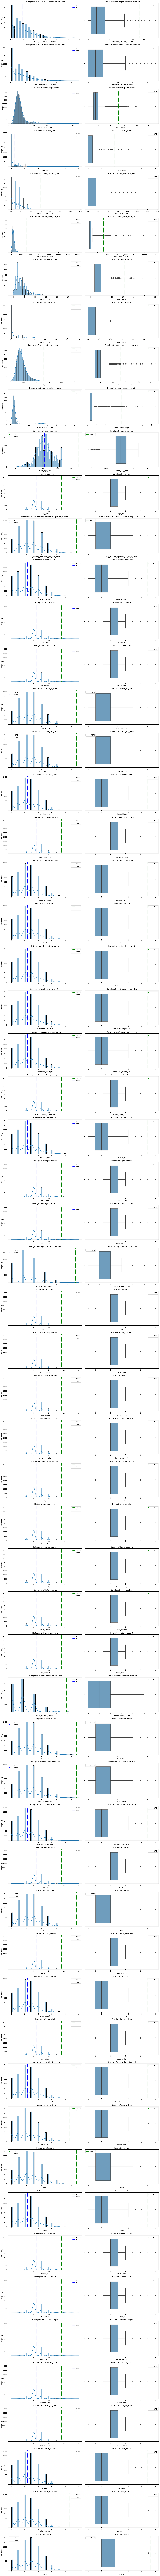

In [24]:
# visualize and understand the distribution and potential outliers in the numeric columns of the DataFrame


# To ignore all warnings (not recommended in most cases):
warnings.filterwarnings("ignore")



# Set up the figure and axes
fig, axes = plt.subplots(len(numeric_columns_filled.columns), 2, figsize=(15, 4 * len(numeric_columns_filled.columns)))

for i, col in enumerate(numeric_columns_filled.columns):
    
    upper_bound = df[col].mean() + 4 * df[col].std()
    mean = df[col].mean()
    
    # Plot histogram
    bins = 'auto'  # You can choose a different binning strategy here
    sns.histplot(df[col], ax=axes[i, 0], bins=bins, kde=True, edgecolor='black')
    
   
    axes[i, 0].set_title(f'Histogram of {col}')
    
    axes[i, 0].axvline(upper_bound, color='g', linestyle='--', label=f'4*STD') # Draw the 5*STD line on boxplot
    axes[i, 0].axvline(mean, color='b', linestyle='--', label='Mean')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].legend()
    
    # Plot box plot
    sns.boxplot(x=df[col], ax=axes[i, 1], showfliers=True, boxprops=dict(alpha=0.7))
   


    axes[i, 1].axvline(upper_bound, color='g', linestyle='--', label=f'4*STD')  
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()






As observed in the analysis, a threshold value of 4 emerges as the optimal choice.

In [25]:
# calculates z-scores for numeric columns in the DataFrame numeric_columns_filled, sets a threshold of 4 to identify outliers, and creates a new DataFrame df_no_outliers containing rows without outliers based on the specified threshold.

z_scores = np.abs(stats.zscore(numeric_columns_filled))
threshold = 4
df_no_outliers = numeric_columns_filled[(z_scores < threshold).all(axis=1)]


In [26]:
#Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the scaler on your numeric columns
df_scaled = scaler.fit_transform(df_no_outliers)

# Create a new DataFrame with the scaled values
numeric_df = pd.DataFrame(df_scaled, columns=df_no_outliers.columns)
#numeric_df

In [27]:
# Concatenate the DataFrames along columns (axis=1)
clean_data = pd.concat([df["user_id"], numeric_df, object_columns_filled, bool_columns_filled], axis=1)
clean_data

user_id  mean_flight_discount_amount  mean_hotel_discount_amount  \
0       23557                     0.444444                    0.166667   
1       94883                     0.000000                    0.250000   
2      101486                     0.055556                    0.083333   
3      101961                     0.000000                    0.500000   
4      106907                     0.388889                    0.250000   
...       ...                          ...                         ...   
5993   792549                          NaN                         NaN   
5994   796032                          NaN                         NaN   
5995   801660                          NaN                         NaN   
5996   811077                          NaN                         NaN   
5997   844489                          NaN                         NaN   

      mean_page_clicks  mean_seats  mean_checked_bags  mean_base_fare_usd  \
0             0.257656    0.000000           0.428571            0.104506   
1             0.397368    0.000000           0.714286            0.271175   
2             0.111654    0.000000           0.000000            0.128215   
3             0.537719    0.285714           0.285714            0.482661   
4             0.708947    0.571429           0.714286            0.564896   
...                ...         ...                ...                 ...   
5993               NaN         NaN                NaN                 NaN   
5994               NaN         NaN                NaN                 NaN   
5995               NaN         NaN                NaN                 NaN   
5996               NaN         NaN                NaN                 NaN   
5997               NaN         NaN                NaN                 NaN   

      mean_nights  mean_rooms  mean_hotel_per_room_usd  ...  rooms  seats  \
0        0.260417         0.0                 0.269097  ...  0.750  0.750   
1        0.375000         0.0                 0.453819  ...  0.750  0.750   
2        0.250000         0.0                 0.304167  ...  0.000  0.000   
3        0.187500         0.0                 0.197917  ...  0.250  0.500   
4        0.437500         0.4                 0.255000  ...  0.625  0.625   
...           ...         ...                      ...  ...    ...    ...   
5993          NaN         NaN                      NaN  ...    NaN    NaN   
5994          NaN         NaN                      NaN  ...    NaN    NaN   
5995          NaN         NaN                      NaN  ...    NaN    NaN   
5996          NaN         NaN                      NaN  ...    NaN    NaN   
5997          NaN         NaN                      NaN  ...    NaN    NaN   

      session_end  session_id  session_length  session_start  sign_up_date  \
0        1.000000    1.000000        1.000000       1.000000      1.000000   
1        1.000000    1.000000        1.000000       1.000000      1.000000   
2        0.333333    0.333333        0.333333       0.333333      0.333333   
3        0.666667    0.666667        0.666667       0.666667      0.666667   
4        0.833333    0.833333        0.833333       0.833333      0.833333   
...           ...         ...             ...            ...           ...   
5993          NaN         NaN             NaN            NaN           NaN   
5994          NaN         NaN             NaN            NaN           NaN   
5995          NaN         NaN             NaN            NaN           NaN   
5996          NaN         NaN             NaN            NaN           NaN   
5997          NaN         NaN             NaN            NaN           NaN   

      trip_airline  trip_duration   trip_id  
0            0.750          0.750  0.666667  
1            0.750          0.750  0.666667  
2            0.000          0.000  0.000000  
3            0.500          0.500  0.444444  
4            0.625          0.625  0.555556  
...            ...            ...       ...  
5993    

## Creating Features for Analysis

we are creating a set of new features that could help us better understand how customers behave. These features are like clues that might tell us which of our five special offers a customer is most likely to be interested in.
It's important to remember that we might not end up using all of these features; we're just gathering them as a starting point to figure out which ones are the most important.

Five special offers in mind: 'One Night Free Hotel With Flight,' 'Free Hotel Meal,' 'Free Cancellation,' 'Free Checked Bag,' and 'Exclusive Discounts.' Each feature is designed to help us see how customers act in relation to these offers. This will help us figure out how important each offer is when we group our customers for analysis.

In [28]:
# Calculate the percentage of flight bookings under discount


# Assuming 'user_id' is the column you want to group by
grouped_flight_booked = clean_data.groupby('user_id')['flight_booked'].sum().reset_index()

# Rename the 'flight_booked' column to 'total_flights_booked'
grouped_flight_booked.rename(columns={'flight_booked': 'total_flights_booked'}, inplace=True)

# Merge the grouped data back into the original DataFrame based on 'user_id'
clean_data = clean_data.merge(grouped_flight_booked, on='user_id', how='left')


clean_data['percentage_flight_discount'] = clean_data['total_flights_booked'] / clean_data['num_sessions']


In [29]:
# Calculate the 'average_dollars_saved' column

grouped_flight_discount = clean_data.groupby('user_id')['flight_discount'].sum().reset_index()

grouped_flight_discount.rename(columns={'flight_discount': 'total_flight_discount'}, inplace=True)

clean_data = clean_data.merge(grouped_flight_discount, on='user_id', how='left')



grouped_hotel_discount = clean_data.groupby('user_id')['hotel_discount'].sum().reset_index()

grouped_hotel_discount.rename(columns={'hotel_discount': 'total_hotel_discount'}, inplace=True)

clean_data = clean_data.merge(grouped_hotel_discount, on='user_id', how='left')


clean_data['average_dollars_saved'] = (clean_data['total_flight_discount'] + clean_data['total_hotel_discount']) / 2


In [30]:
# Calculate the scaled average dollars saved amount with haversine distance
epsilon = 1e-10
clean_data['scaled_dollars_saved_haversine'] = clean_data['average_dollars_saved'] / (clean_data['distance_km'] + epsilon)


In [31]:
# Cancellation Rate

grouped_cancellation = clean_data.groupby('user_id')['cancellation'].sum().reset_index()

grouped_cancellation.rename(columns={'cancellation': 'total_cancellations'}, inplace=True)

clean_data = clean_data.merge(grouped_cancellation, on='user_id', how='left')



clean_data['cancellation_rate'] = clean_data['total_cancellations'] / clean_data['num_sessions']


In [32]:
# Engagement Score

grouped_page_clicks = clean_data.groupby('user_id')['page_clicks'].sum().reset_index()

grouped_page_clicks.rename(columns={'page_clicks': 'total_page_clicks'}, inplace=True)

clean_data = clean_data.merge(grouped_page_clicks, on='user_id', how='left')



grouped_hotel_booked = clean_data.groupby('user_id')['hotel_booked'].sum().reset_index()

grouped_hotel_booked.rename(columns={'hotel_booked': 'total_hotels_booked'}, inplace=True)

clean_data = clean_data.merge(grouped_hotel_booked, on='user_id', how='left')


clean_data['engagement_score'] = clean_data['total_page_clicks'] + clean_data['total_flights_booked'] + clean_data['total_hotels_booked']


In [33]:

# Flight-Hotel Combination Percentage
clean_data['flight_hotel_combination'] = (clean_data['total_flights_booked'] > 0).astype("float64") + (clean_data['total_hotels_booked'] > 0).astype("float64")


In [34]:
# Hotel Booking Frequency
clean_data['hotel_booking_frequency'] = clean_data['total_hotels_booked'] / clean_data['num_sessions']


In [35]:
# Average Dollars Saved on Hotels
clean_data['average_dollars_saved_hotels'] = clean_data['total_hotel_discount'] / clean_data['total_hotels_booked']


# Hotel-Only Bookings
clean_data['hotel_only_sessions_percentage'] = (clean_data['total_hotels_booked'] / clean_data['num_sessions']) * 100


In [36]:
# Browsing Only Engagement
clean_data['browsing_only_engagement'] = clean_data['engagement_score'] - clean_data['total_flights_booked']


In [37]:
# Define the threshold for short trips
short_trip_threshold = timedelta(days=3)

short_trip_threshold.total_seconds()


# Create a short trip indicator
clean_data['short_trip'] = (clean_data['trip_duration'] <= short_trip_threshold.total_seconds())


In [38]:

# Create a binary feature indicating if the customer has ever canceled
clean_data['ever_canceled'] = (clean_data['total_cancellations'] > 0)


# Calculate the proportion of cancellations using total flights, total hotels, and total cancellations
clean_data['proportion_of_cancellations'] = clean_data['total_cancellations'] / (clean_data['total_flights_booked'] + clean_data['total_hotels_booked'])


grouped_checked_bags = clean_data.groupby('user_id')['checked_bags'].sum().reset_index()

grouped_checked_bags.rename(columns={'checked_bags': 'total_checked_bags'}, inplace=True)

clean_data = clean_data.merge(grouped_checked_bags, on='user_id', how='left')




In [39]:
clean_data.columns

Index(['user_id', 'mean_flight_discount_amount', 'mean_hotel_discount_amount',
       'mean_page_clicks', 'mean_seats', 'mean_checked_bags',
       'mean_base_fare_usd', 'mean_nights', 'mean_rooms',
       'mean_hotel_per_room_usd', 'mean_session_length', 'mean_age_year',
       'age_year', 'avg_booking_departure_gap_days_hotels', 'base_fare_usd',
       'birthdate', 'cancellation', 'check_in_time', 'check_out_time',
       'checked_bags', 'conversion_rate', 'departure_time', 'destination',
       'destination_airport', 'destination_airport_lat',
       'destination_airport_lon', 'discount_flight_proportion', 'distance_km',
       'flight_booked', 'flight_discount', 'flight_discount_amount', 'gender',
       'has_children', 'home_airport', 'home_airport_lat', 'home_airport_lon',
       'home_city', 'home_country', 'hotel_booked', 'hotel_discount',
       'hotel_discount_amount', 'hotel_name', 'hotel_per_room_usd',
       'last_minute_booking', 'married', 'nights', 'num_sessions',
     

### Check New Features for Missing and Infinite Values

Because I have used calculations to create the new features, I want to check to make sure I haven't created any new missing or infinite values. If I have I will then want to replace them.

In [40]:
# Check for missing values


clean_data.isna().sum()

numeric_columns_clean_data = clean_data.select_dtypes(include=["float64", "int64"])

# Fill missing values in numeric columns with the median of each column
final_data = numeric_columns_clean_data.fillna(numeric_columns_clean_data.mean())

final_data.isna().sum()


user_id                           0
mean_flight_discount_amount       0
mean_hotel_discount_amount        0
mean_page_clicks                  0
mean_seats                        0
                                 ..
average_dollars_saved_hotels      0
hotel_only_sessions_percentage    0
browsing_only_engagement          0
proportion_of_cancellations       0
total_checked_bags                0
Length: 79, dtype: int64

In [41]:
final_data1 = final_data.to_csv("final_data1.csv")

In [42]:
final_data.columns

Index(['user_id', 'mean_flight_discount_amount', 'mean_hotel_discount_amount',
       'mean_page_clicks', 'mean_seats', 'mean_checked_bags',
       'mean_base_fare_usd', 'mean_nights', 'mean_rooms',
       'mean_hotel_per_room_usd', 'mean_session_length', 'mean_age_year',
       'age_year', 'avg_booking_departure_gap_days_hotels', 'base_fare_usd',
       'birthdate', 'cancellation', 'check_in_time', 'check_out_time',
       'checked_bags', 'conversion_rate', 'departure_time', 'destination',
       'destination_airport', 'destination_airport_lat',
       'destination_airport_lon', 'discount_flight_proportion', 'distance_km',
       'flight_booked', 'flight_discount', 'flight_discount_amount', 'gender',
       'has_children', 'home_airport', 'home_airport_lat', 'home_airport_lon',
       'home_city', 'home_country', 'hotel_booked', 'hotel_discount',
       'hotel_discount_amount', 'hotel_name', 'hotel_per_room_usd',
       'last_minute_booking', 'married', 'nights', 'num_sessions',
     

### View Correlations Between Features .

Now that I have handled the missing  in the new features, I am checking correlations between all features so that I can start to decide on which features I want to use in my K-means algorithm. I don't want to use features that are too closely correlated, this is because it can lead to problems like making some features less useful, making it harder to understand the importance of individual features, and making the model less reliable for making predictions, but I do want to use metrics that are likely to capture customer behaviour that is relevant to the perks.

The below code will create a heatmap so that I can assess correlations between features, it is going to be rather large and difficult to interpret to begin with, but that's okay because the aim is to evaluate everything to give me an indication of which features I can exclude, and which could be potential contenders. At this stage I don't need to be able to look into everything in detail, I only need to be able to remove the features that don't fit my criteria.

Based on this I am going to narrow it down further with a new heatmap with the majority of those features eliminated, so that I can get a clearer picture of some of the more suitable features. Below is the result.

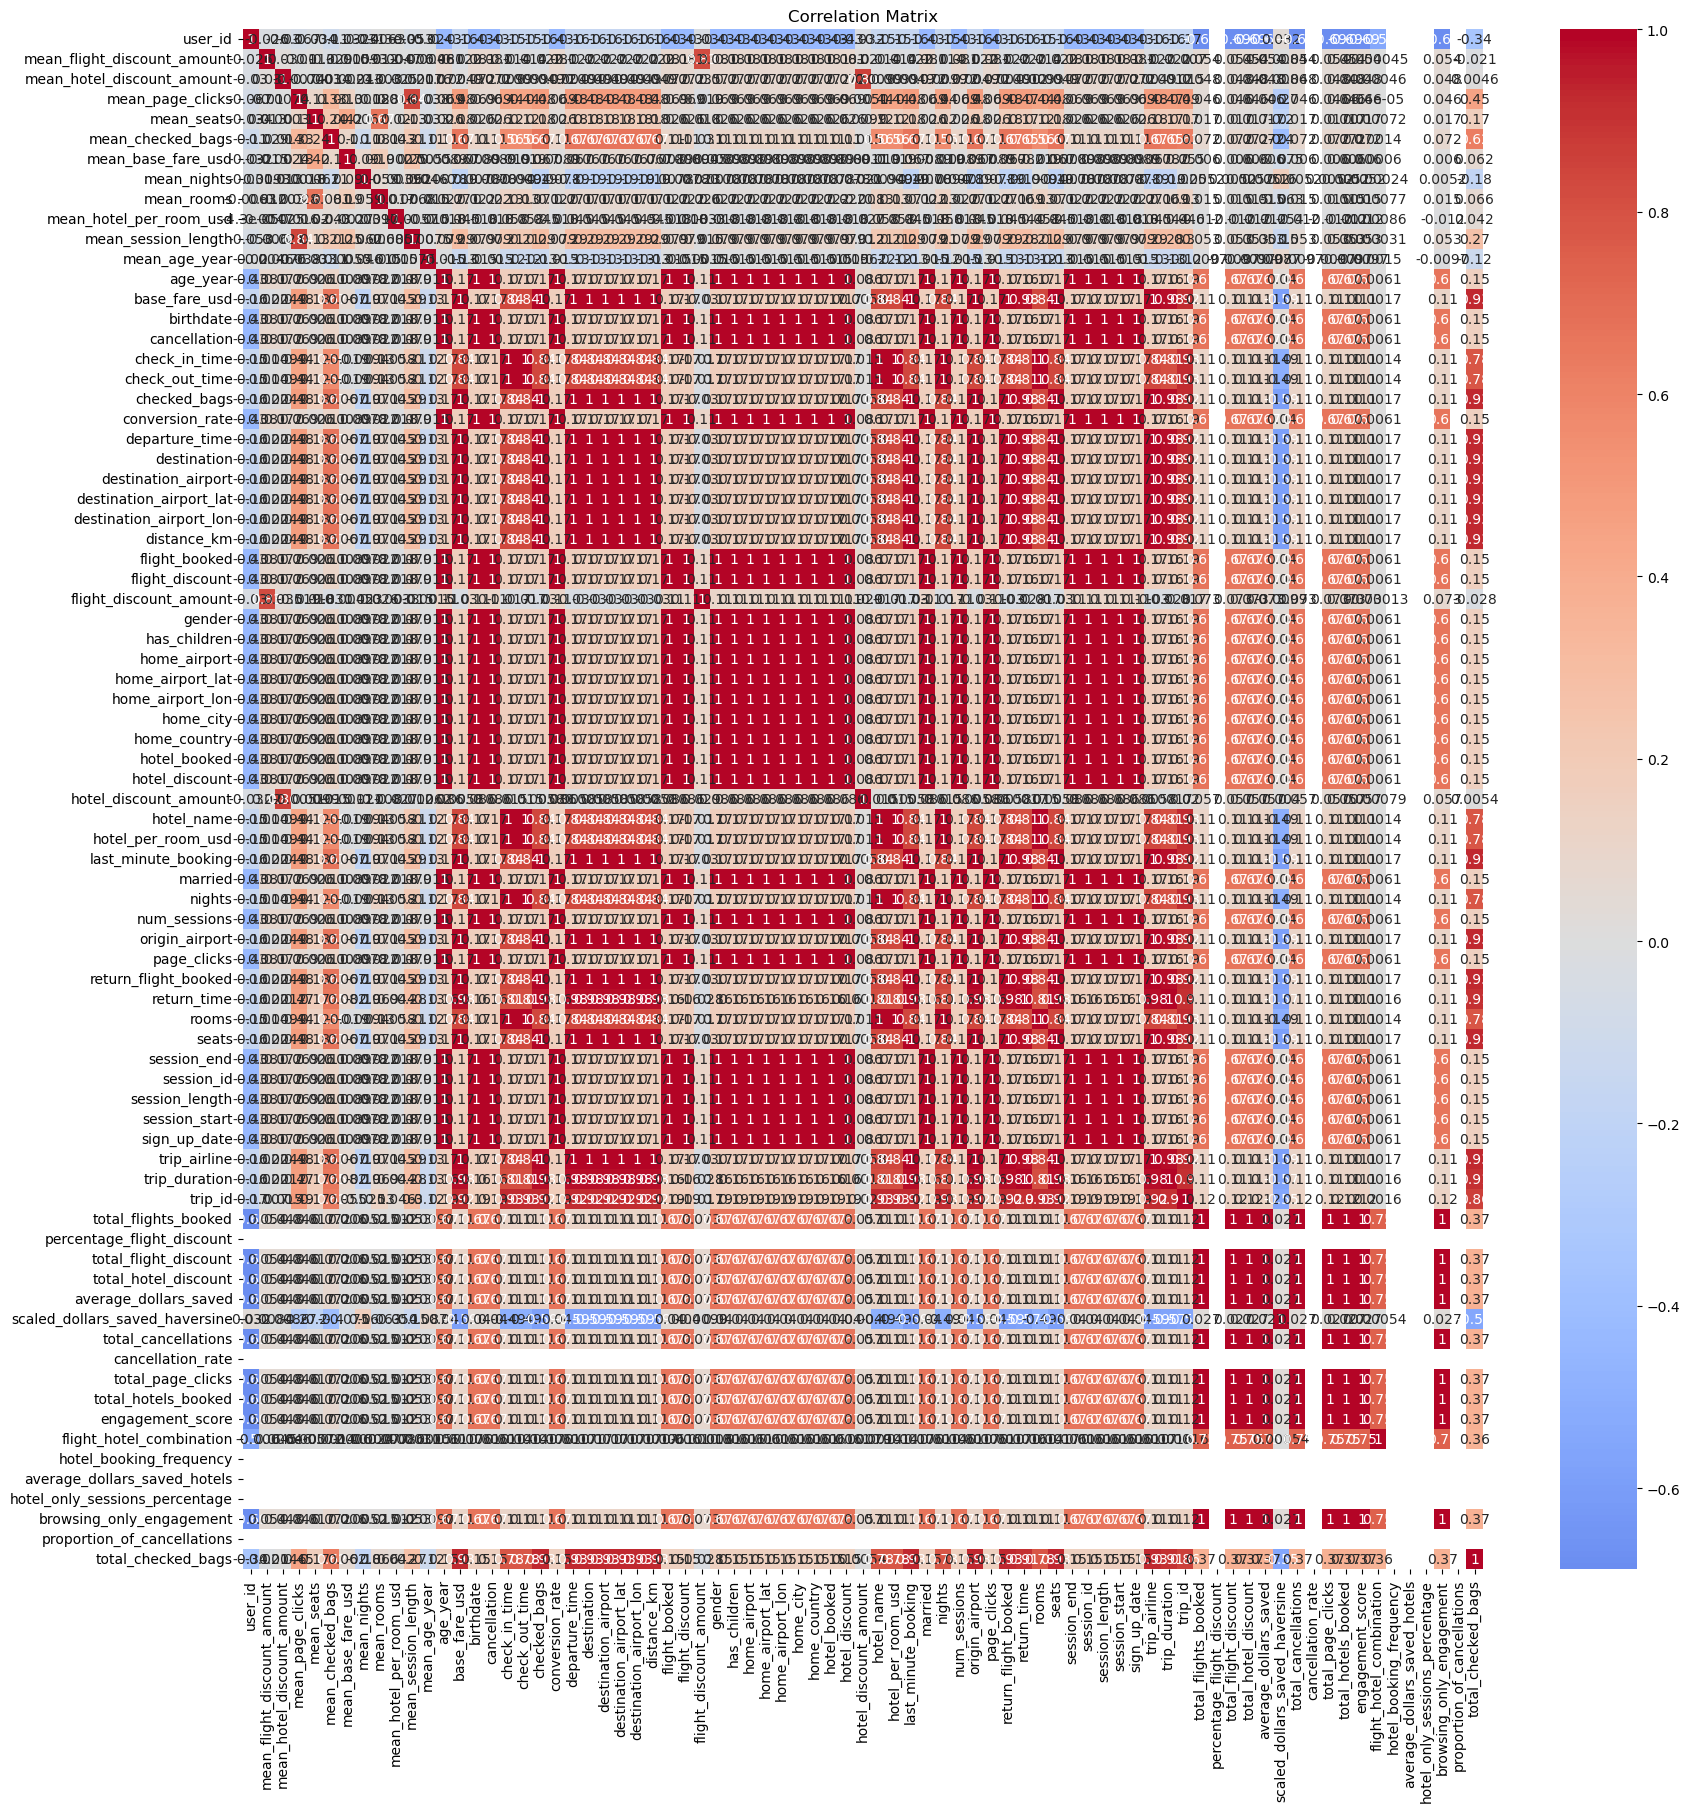

In [72]:
# Calculate correlations between specified metrics
all_columns = ['user_id', 'mean_flight_discount_amount', 'mean_hotel_discount_amount',
       'mean_page_clicks', 'mean_seats', 'mean_checked_bags',
       'mean_base_fare_usd', 'mean_nights', 'mean_rooms',
       'mean_hotel_per_room_usd', 'mean_session_length', 'mean_age_year',
       'age_year', 'base_fare_usd', 'birthdate', 'cancellation',
       'check_in_time', 'check_out_time', 'checked_bags', 'conversion_rate',
       'departure_time', 'destination', 'destination_airport',
       'destination_airport_lat', 'destination_airport_lon', 'distance_km',
       'flight_booked', 'flight_discount', 'flight_discount_amount', 'gender',
       'has_children', 'home_airport', 'home_airport_lat', 'home_airport_lon',
       'home_city', 'home_country', 'hotel_booked', 'hotel_discount',
       'hotel_discount_amount', 'hotel_name', 'hotel_per_room_usd',
       'last_minute_booking', 'married', 'nights', 'num_sessions',
       'origin_airport', 'page_clicks', 'return_flight_booked', 'return_time',
       'rooms', 'seats', 'session_end', 'session_id', 'session_length',
       'session_start', 'sign_up_date', 'trip_airline', 'trip_duration',
       'trip_id', 'total_flights_booked', 'percentage_flight_discount',
       'total_flight_discount', 'total_hotel_discount',
       'average_dollars_saved', 'scaled_dollars_saved_haversine',
       'total_cancellations', 'cancellation_rate', 'total_page_clicks',
       'total_hotels_booked', 'engagement_score', 'flight_hotel_combination',
       'hotel_booking_frequency', 'average_dollars_saved_hotels',
       'hotel_only_sessions_percentage', 'browsing_only_engagement',
       'proportion_of_cancellations', 'total_checked_bags']




correlation_matrix = final_data[all_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={'fontsize': 10})
plt.title("Correlation Matrix")
plt.show()

In [ ]:
## Creating new attributes:
Looking at our table, let's see which fields carry information about behaviour that might be relevant to our hypothesized perks. We need to know for each perk, what kind of travel behaviour indicates affinity to the perk. We already have some metrics that will be useful for further analysis of customer segmentation and perks offering. Let's first take a look at them, and then decide what more metrics we can calculate before moving forward:

In [ ]:
# 1. Free hotel meal:
* Families, especially those with children, and large tour groups might prefer the convenience of a hotel meal to simplify logistics and keep meals consistent.
* Elderly Travelers might prefer the convenience and safety of dining in the hotel rather than venturing out, especially in the evening.
### Relevant attributes:
    mean_age_year, has_children, mean_seats, mean_checked_bags, and mean_rooms

# Atributes to calculate: free_meal_index

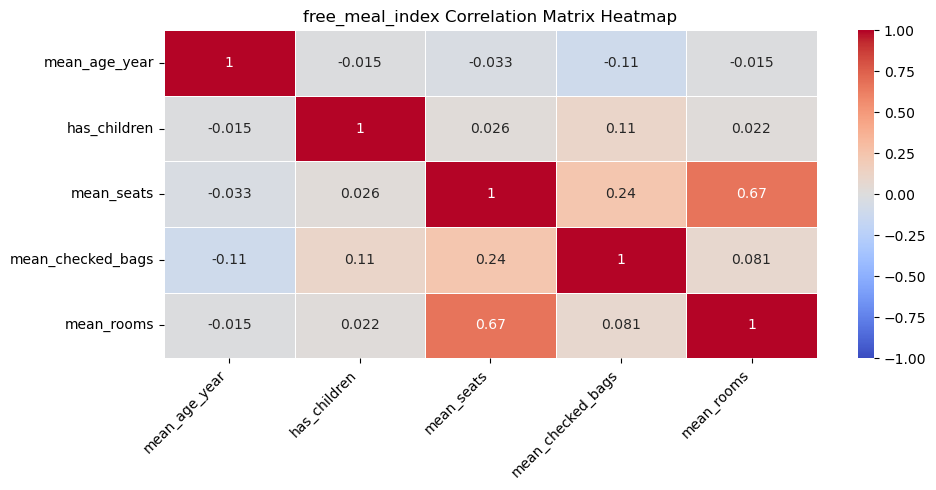

In [43]:
   
# Defining the correlation_columns list
free_meal_correlation_columns = ['mean_age_year', 'has_children', 'mean_seats', 
                                'mean_checked_bags', 'mean_rooms']

# Compute the correlation matrix for the free_meal_index
correlation_matrix = final_data[free_meal_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("free_meal_index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()    

#### Calculate the free_meal_index:

As we already saw, 'mean_seats', 'mean_rooms' has a strong correlation, so I'll drop 'mean_rooms' to not include the same information. Normally unless we have strong reasons we’d probably use a uniform scaling, in this case 0.25 for each.

In [44]:
# Define the weights for each feature
weights = {
    'mean_age_year': 0.25,
    'has_children': 0.25,
    'mean_seats': 0.25,
    'mean_checked_bags': 0.25
}

# Initialize the free_meal_index column to 0
final_data['free_meal_index'] = 0

# Calculate the free_meal_index using the weighted average
for column, weight in weights.items():
    final_data['free_meal_index'] += final_data[column] * weight

## 2. Free checked bags:
Long-Term Travelers tend to have more luggage.

Families might have extra luggage, especially when travelling with children .

Travelers Booking Round Trips usually prefer for convenience and predictability. Having a free checked bag aligns with this mindset, offering a hassle-free experience by eliminating potential additional costs or decisions about luggage on both legs of their journey.

* Relevant Metrics: mean_session_length, has_children, mean_checked_bags, and trip_duration

## Metric to calculate: free_bag_index

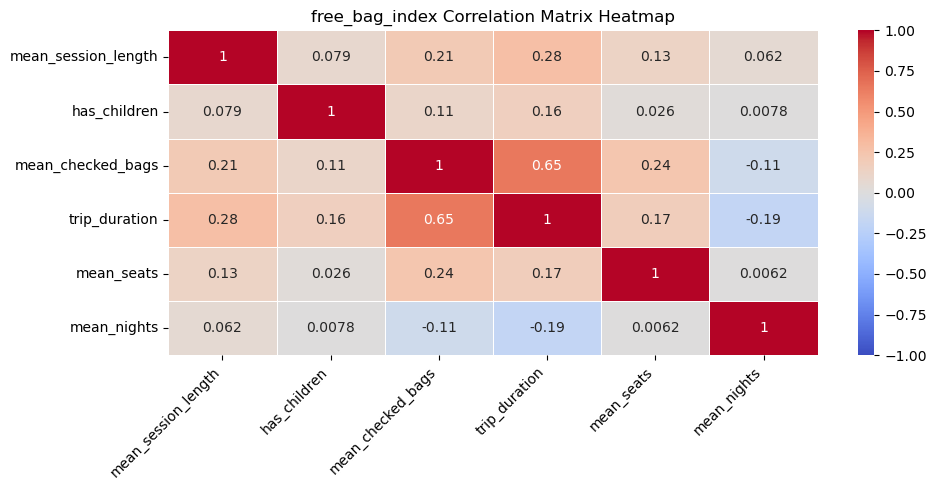

In [45]:
# Defining the correlation_columns list
free_bag_correlation_columns = ['mean_session_length', 'has_children', 
                                'mean_checked_bags', 'trip_duration', 'mean_seats', 'mean_nights']
    

# Compute the correlation matrix for the free_bag_index
correlation_matrix = final_data[free_bag_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("free_bag_index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

## Observations from the "free_bag_index" Correlation Matrix:
The correlation between trip_duration and mean_checked_bags stands out as the strongest and is meaningful from a business perspective.

Most of the other correlations are weak, but given the business context, they might still be significant for the index. Even with weak correlations, has_children might be an essential metric due to its business significance.

A weighted average can be a good method to calculate the index. As we don't have a strong correlation between metrics, I'll use a uniform scaling, 0.20 for each.

## Metric to calculate: free_bag_index

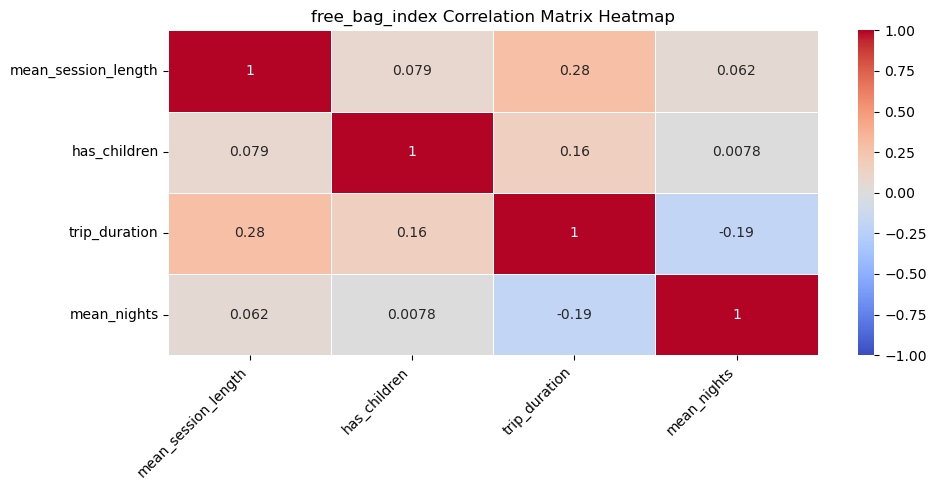

In [46]:
# Defining the correlation_columns list
free_bag_correlation_columns = ['mean_session_length', 'has_children', 'trip_duration', 'mean_nights']

# Compute the correlation matrix for the free_bag_index
correlation_matrix = final_data[free_bag_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("free_bag_index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

### Observations from the "free_bag_index" Correlation Matrix:
The correlation between trip_duration and mean_checked_bags stands out as the strongest and is meaningful from a business perspective.

Most of the other correlations are weak, but given the business context, they might still be significant for the index. Even with weak correlations, has_children might be an essential metric due to its business significance.

A weighted average can be a good method to calculate the index. As we don't have a strong correlation between metrics, I'll use a uniform scaling, 0.20 for each.

In [47]:
# Define the weights for each feature
weights = {
    'mean_session_length': 0.25,
    'has_children': 0.25,
    'trip_duration': 0.25,
    'mean_nights': 0.25
}

 
                            
# Calculate the free_bag_index using the weighted average
final_data['free_bag_index'] = 0  

for column, weight in weights.items():
    final_data['free_bag_index'] += final_data[column] * weight

### 3. No cancellation fees:
* Uncertain Travelers who aren’t sure about their plans or are booking well in advance might value this perk.
* Travelers with a High Number of Cancelled Trips are likely value flexibility in future bookings to avoid incurring costs.
Relevant Metrics: avg_booking_departure_gap_days and total_cancellations

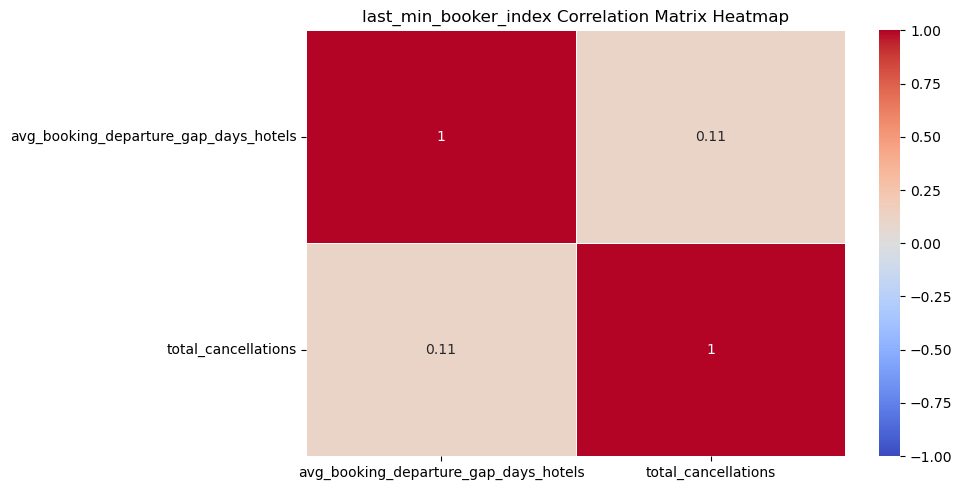

In [48]:
# Defining the correlation_columns list
last_min_correlation_columns = ['avg_booking_departure_gap_days_hotels', 'total_cancellations']
    
# Compute the correlation matrix for the last_min_booker_index
scaled_correlation_matrix = final_data[last_min_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(scaled_correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Set the title and show the plot
plt.title("last_min_booker_index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()


The correlation coefficient of 0.11 between the two metrics suggests a very weak positive linear relationship, which means that the two metrics are capturing somewhat different aspects of the behavior, which is good for differentiation. If they were highly correlated, they'd be redundant.

Our analysis indicates two primary user behavior types:

Planning in Advance: Users with longer average booking departure gaps tend to plan their trips well in advance. This may indicate they are less likely to cancel bookings due to more concrete travel plans.
Low Cancellation Propensity: Users with lower cancellation proportions are less likely to cancel bookings, suggesting a stronger commitment to travel plans.


##### Since both columns are already scaled, we can directly use them in our index calculation using weighted average method.

In [49]:
# Define weights
w1 = 0.5  # Weight for total_cancellation
w2 = 0.5  # Weight for avg_booking_departure_gap_days

'''
Subtracting the scaled_avg_booking_departure_gap_days from max_value will ensure that 
lower values (indicating last-minute booking) contribute more to the index.
'''
# Calculate the last_min_booker_index using the weighted average
max_gap = final_data['avg_booking_departure_gap_days_hotels'].max()

final_data['last_min_booker_index'] = w1 * final_data['total_cancellations'] + w2 * (max_gap - final_data['avg_booking_departure_gap_days_hotels'])  

### 4. Exclusive discounts:
This one is a bit unclear compared to the other perks. Based on what the Marketing Manager said, we're looking for price-sensitive customers.

Relevant Metrics:

conversion_rate: A low conversion rate, indicating unwillingness to buy except at a low enough price 

avg_session_duration_minute and avg_page_clicks: Longer values might indicate bargain-hunting behaviour 

avg_flight_discount_amount, discounted_flight_proportion, avg_hotel_discount_amount and discounted_hotel_proportion

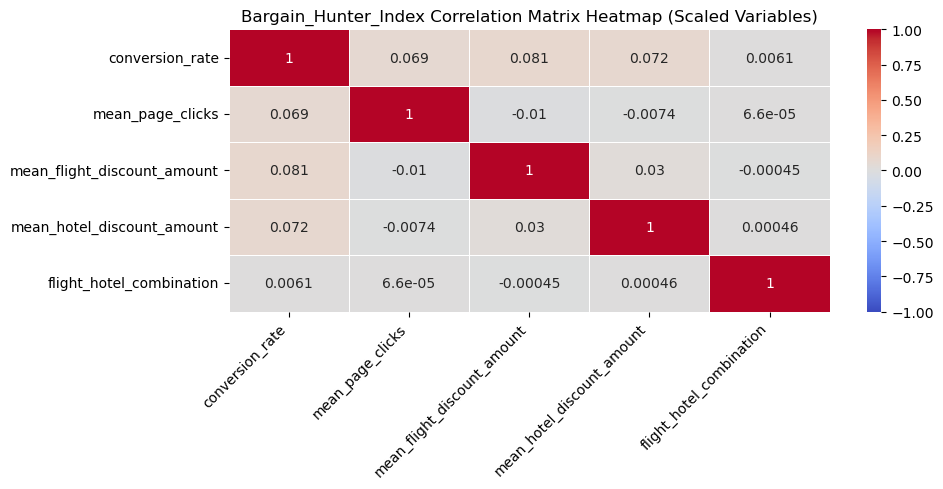

In [50]:
# Defining the correlation_columns list
bargain_correlation_columns = [
    'conversion_rate',
    'mean_page_clicks',
    'mean_flight_discount_amount',
    'mean_hotel_discount_amount',
    'flight_hotel_combination'
    
]
  
    
# Compute the correlation matrix for the bargain_hunter_index relevant metrics using the scaled columns
scaled_correlation_matrix = final_data[bargain_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(scaled_correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("Bargain_Hunter_Index Correlation Matrix Heatmap (Scaled Variables)")
plt.tight_layout()
plt.show()

In [51]:
# Calculate the bargain_hunter_index using the weighted average
# Define the weights for each feature
weights = {
    'conversion_rate': 0.2,
    'mean_page_clicks': 0.2,
    'mean_flight_discount_amount': 0.2,
    'mean_hotel_discount_amount': 0.2,
    'flight_hotel_combination': 0.2,
}


# Calculate the bargain_hunting_index for each row
final_data['bargain_hunting_index'] = 0

for column, weight in weights.items():
    value = (1 - final_data[column]) if column == 'conversion_rate' else final_data[column]
    final_data['bargain_hunting_index'] += weight * value

### 5. 1-night free hotel with a flight:

Relevant Metrics: total_flights_booked, session_length, has_children ,total_hotels_booked



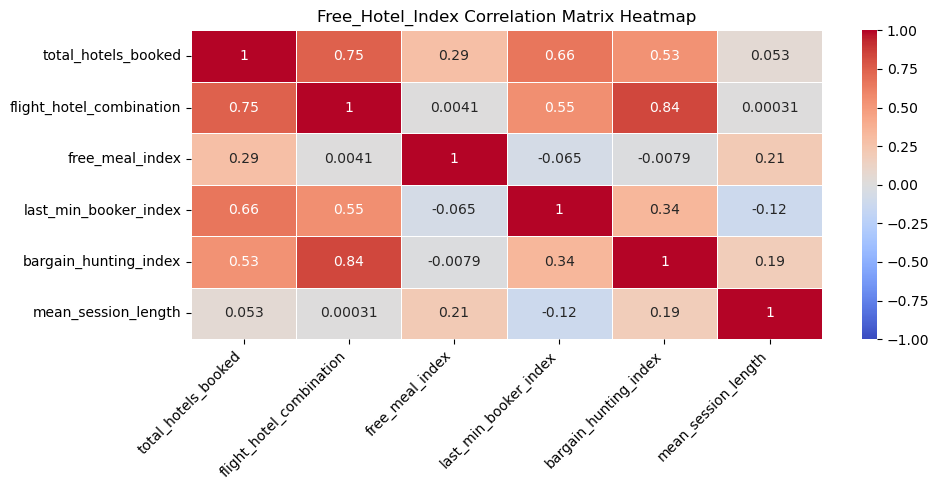

In [52]:
# Defining the correlation_columns list
hotel_correlation_columns = [
       'total_hotels_booked', 'flight_hotel_combination', 'free_meal_index',
       'last_min_booker_index', 'bargain_hunting_index','mean_session_length' 
]
    
# Compute the correlation matrix for the fee_hotel_index
correlation_matrix = final_data[hotel_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("Free_Hotel_Index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

In [53]:
# Calculate the free_hotel_index using the weighted average
# Define the weights for each feature
weights = {
    'flight_hotel_combination': 0.50,
    'mean_session_length' : 0.50
}



# Initialize the free_hotel_index column to 0
final_data['free_hotel_index'] = 0

# Calculate the free_hotel_index for each row
for column, weight in weights.items():
    final_data['free_hotel_index'] += final_data[column] * weight

# Verify the creation of all the indexes
final_data.head()

user_id  mean_flight_discount_amount  mean_hotel_discount_amount  \
0    23557                     0.444444                    0.166667   
1    94883                     0.000000                    0.250000   
2   101486                     0.055556                    0.083333   
3   101961                     0.000000                    0.500000   
4   106907                     0.388889                    0.250000   

   mean_page_clicks  mean_seats  mean_checked_bags  mean_base_fare_usd  \
0          0.257656    0.000000           0.428571            0.104506   
1          0.397368    0.000000           0.714286            0.271175   
2          0.111654    0.000000           0.000000            0.128215   
3          0.537719    0.285714           0.285714            0.482661   
4          0.708947    0.571429           0.714286            0.564896   

   mean_nights  mean_rooms  mean_hotel_per_room_usd  ...  \
0     0.260417         0.0                 0.269097  ...   
1     0.375000         0.0                 0.453819  ...   
2     0.250000         0.0                 0.304167  ...   
3     0.187500         0.0                 0.197917  ...   
4     0.437500         0.4                 0.255000  ...   

   average_dollars_saved_hotels  hotel_only_sessions_percentage  \
0                           1.0                           100.0   
1                           1.0                           100.0   
2                           1.0                           100.0   
3                           1.0                           100.0   
4                           1.0                           100.0   

   browsing_only_engagement  proportion_of_cancellations  total_checked_bags  \
0                  2.000000                          0.5               0.750   
1                  2.000000                          0.5               0.750   
2                  0.666667                          0.5               0.000   
3                  1.333333                          0.5               0.500   
4                  1.666667                          0.5               0.625   

   free_meal_index  free_bag_index  last_min_booker_index  \
0         0.515594        0.523447               0.625000   
1         0.579980        0.634637               0.625000   
2         0.224178        0.154770               0.666667   
3         0.506707        0.536411               0.708333   
4         0.653001        0.662082               0.604167   

   bargain_hunting_index  free_hotel_index  
0               0.573753          1.041686  
1               0.529474          1.206775  
2               0.583442          1.017874  
3               0.674211          1.395738  
4               0.702901          1.376247  

[5 rows x 84 columns]

## Segmenting customers by Fuzzy Segmentation:

In [54]:
# Select only indexes columns
indexes_columns = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 
                   'bargain_hunting_index', 'free_hotel_index']

indexes = final_data[indexes_columns]
indexes.head()


free_meal_index  free_bag_index  last_min_booker_index  \
0         0.515594        0.523447               0.625000   
1         0.579980        0.634637               0.625000   
2         0.224178        0.154770               0.666667   
3         0.506707        0.536411               0.708333   
4         0.653001        0.662082               0.604167   

   bargain_hunting_index  free_hotel_index  
0               0.573753          1.041686  
1               0.529474          1.206775  
2               0.583442          1.017874  
3               0.674211          1.395738  
4               0.702901          1.376247

In [55]:
final_data.describe()

user_id  mean_flight_discount_amount  mean_hotel_discount_amount  \
count    5998.000000                  5998.000000                 5998.000000   
mean   545440.695565                     0.215616                    0.190676   
std     64924.749760                     0.188171                    0.192992   
min     23557.000000                     0.000000                    0.000000   
25%    517152.000000                     0.055556                    0.000000   
50%    540542.000000                     0.166667                    0.166667   
75%    574146.000000                     0.333333                    0.250000   
max    844489.000000                     1.000000                    1.000000   

       mean_page_clicks   mean_seats  mean_checked_bags  mean_base_fare_usd  \
count       5998.000000  5998.000000        5998.000000         5998.000000   
mean           0.269791     0.084370           0.195400            0.148775   
std            0.147285     0.159030           0.183421            0.102503   
min            0.000000     0.000000           0.000000            0.000000   
25%            0.178947     0.000000           0.000000            0.099289   
50%            0.247368     0.000000           0.142857            0.128215   
75%            0.313158     0.114286           0.285714            0.163368   
max            1.000000     1.000000           1.000000            1.000000   

       mean_nights   mean_rooms  mean_hotel_per_room_usd  ...  \
count  5998.000000  5998.000000              5998.000000  ...   
mean      0.286552     0.104961                 0.326026  ...   
std       0.144493     0.184781                 0.140896  ...   
min       0.000000     0.000000                 0.000000  ...   
25%       0.187500     0.000000                 0.237500  ...   
50%       0.250000     0.000000                 0.304167  ...   
75%       0.328125     0.166667                 0.380469  ...   
max       1.000000     1.000000                 1.000000  ...   

       average_dollars_saved_hotels  hotel_only_sessions_percentage  \
count                        5998.0                          5998.0   
mean                            1.0                           100.0   
std                             0.0                             0.0   
min                             1.0                           100.0   
25%                             1.0                           100.0   
50%                             1.0                           100.0   
75%                             1.0                           100.0   
max                             1.0                           100.0   

       browsing_only_engagement  proportion_of_cancellations  \
count               5998.000000                       5998.0   
mean                   1.029454                          0.5   
std                    0.364406                          0.0   
min                    0.000000                          0.5   
25%                    1.000000                          0.5   
50%                    1.000000                          0.5   
75%                    1.000000                          0.5   
max                    2.000000                          0.5   

       total_checked_bags  free_meal_index  free_bag_index  \
count         5998.000000      5998.000000     5998.000000   
mean             0.280885         0.371852        0.311878   
std              0.205826         0.083352        0.087587   
min              0.000000         0.102113        0.068802   
25%              0.125000         0.319668        0.252252   
50%              0.250000         0.369467        0.306914   
75%              0.375000         0.415744        0.349258   
max              1.000000         0.882696        0.765325   

       last_min_booker_index  bargain_hunting_index  free_hotel_index  
count            5998.000000            5998.000000       5998.000000  
mean                0.602144               0.599056          0.99

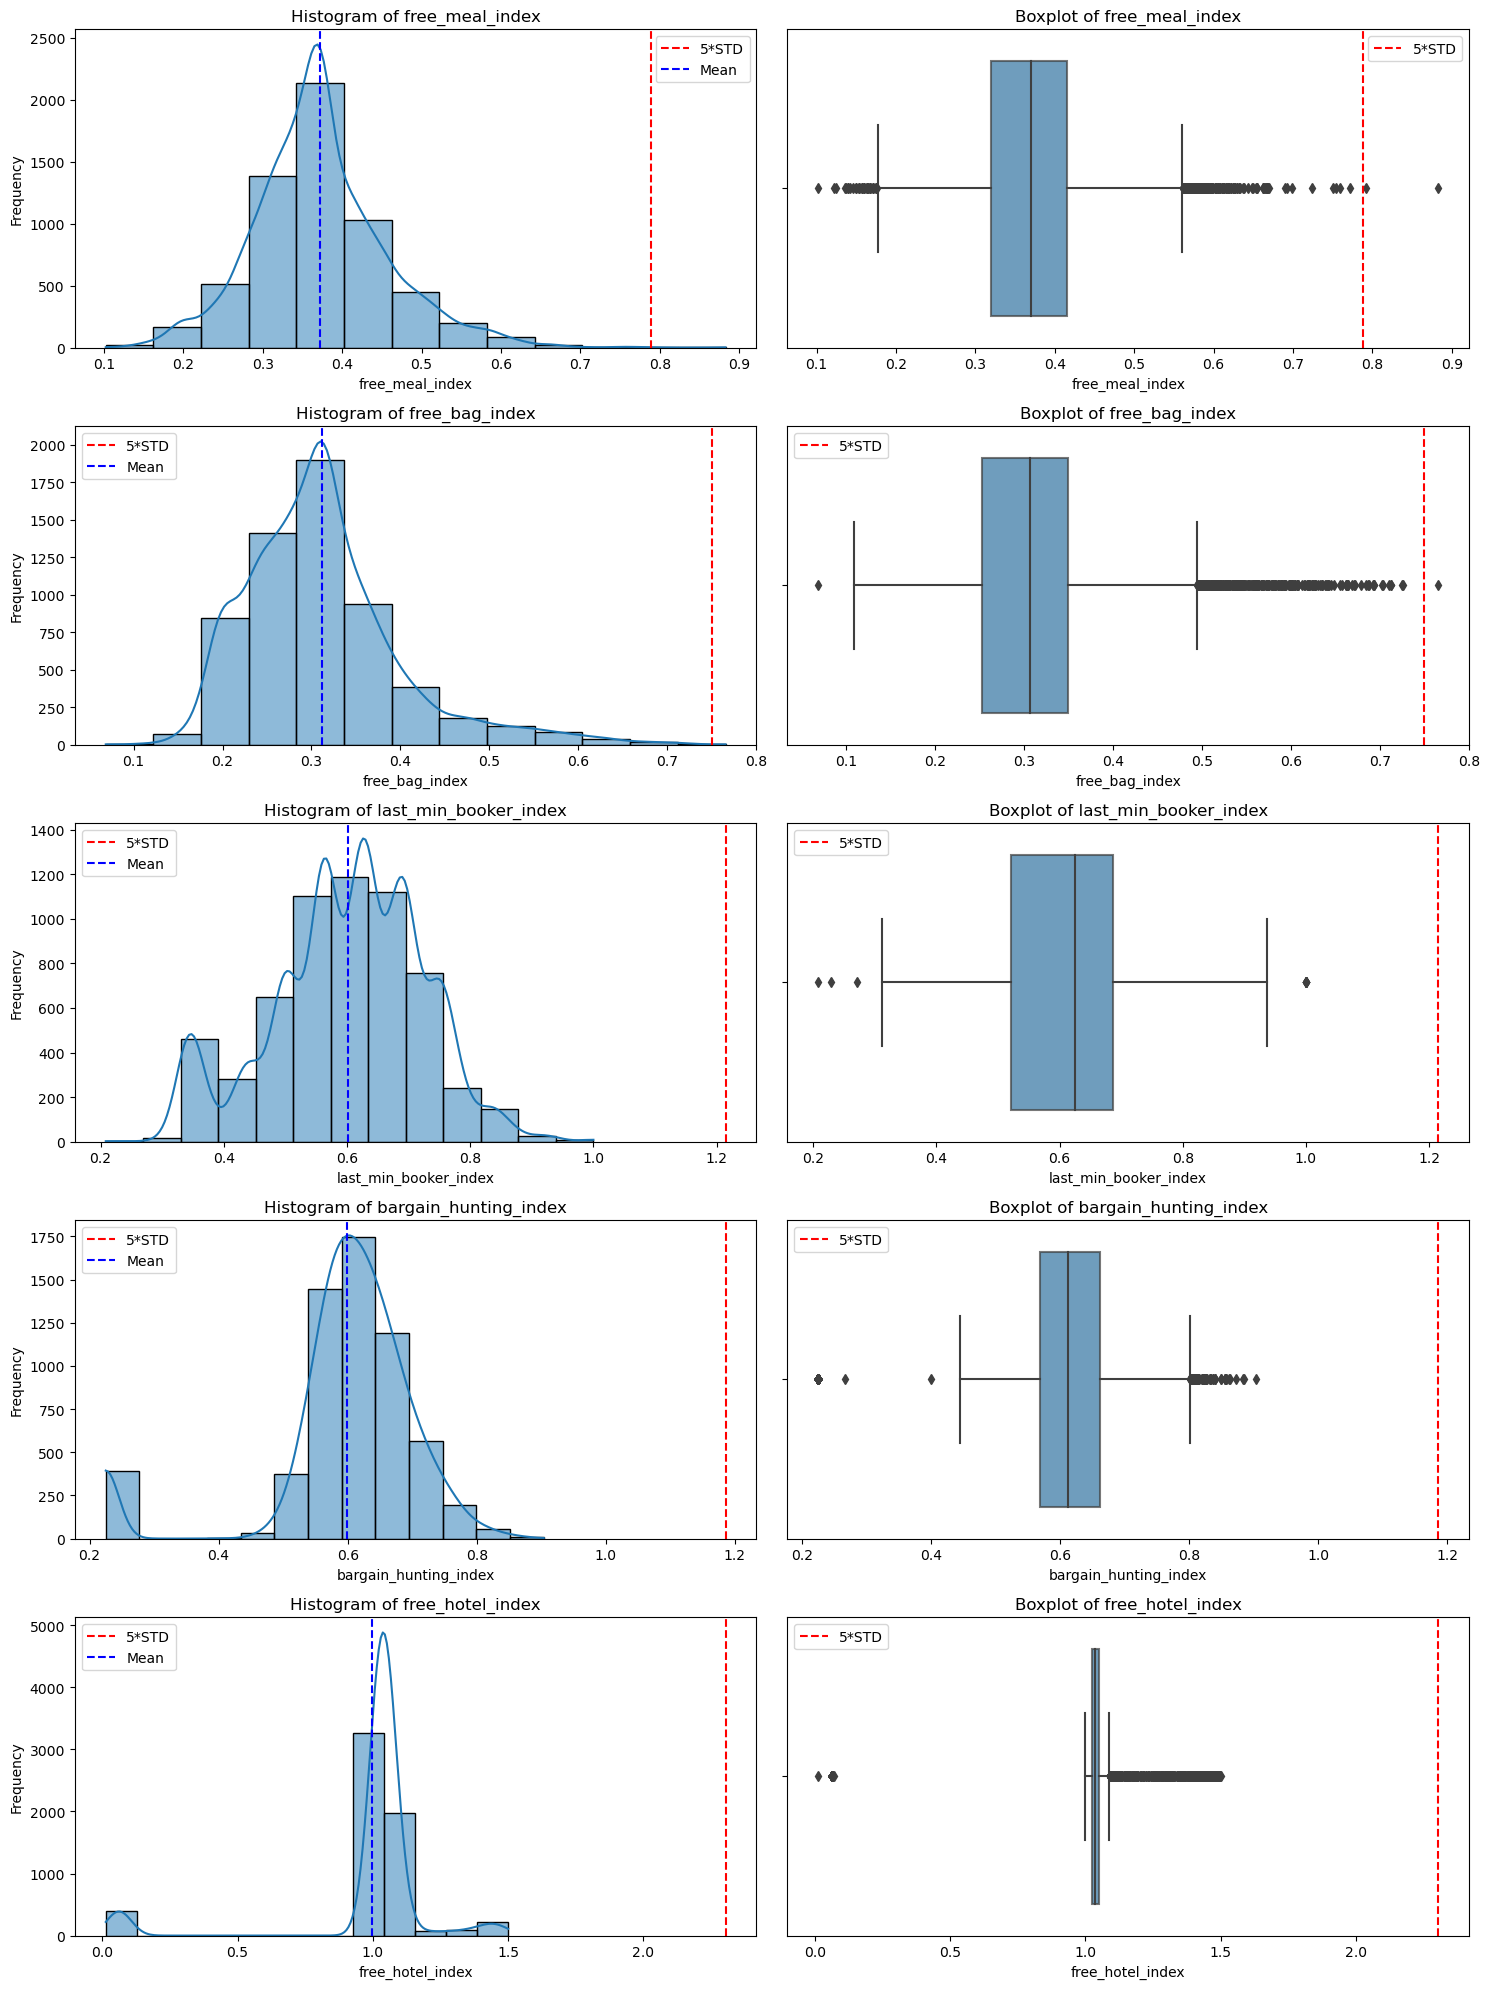

In [56]:
# To ignore all warnings (not recommended in most cases):
warnings.filterwarnings("ignore")

# Set up the figure and axes
fig, axes = plt.subplots(len(indexes_columns), 2, figsize=(15, 4 * len(indexes_columns)))

for i, col in enumerate(indexes_columns):
    upper_bound = final_data[col].mean() + 5 * final_data[col].std()
    mean = final_data[col].mean()
    
    # Plot histogram
    bins = int(np.log2(len(indexes[col])) + 1)  # Sturges' formula
    sns.histplot(indexes[col], ax=axes[i, 0], bins=bins, kde=True, edgecolor='black')
    axes[i, 0].set_title(f'Histogram of {col}')
    #axes[i, 0].axvline(lower_bound, color='r', linestyle='--', label=f'-5*STD')
    axes[i, 0].axvline(upper_bound, color='r', linestyle='--', label=f'5*STD')
    axes[i, 0].axvline(mean, color='b', linestyle='--', label='Mean')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].legend()
    
    # Plot box plot
    sns.boxplot(x=indexes[col], ax=axes[i, 1], showfliers=True, boxprops=dict(alpha=0.7))
    #axes[i, 1].axvline(lower_bound, color='r', linestyle='--', label=f'-5*STD')  # Draw the 5*STD line on boxplot
    axes[i, 1].axvline(upper_bound, color='r', linestyle='--', label=f'5*STD')  # Draw the 5*STD line on boxplot
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Ranking Perk Indexes

For each perk, we'll perform the following tasks:

* Sort the dataset by the respective perk index in descending order.
* Assign ranks starting from 1 to N, where N is the total number of customers.

In [57]:
# Assuming you have a DataFrame named 'final_data' with columns including 'user_id' and the specified perk indexes
perk_indexes = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 'bargain_hunting_index', 'free_hotel_index']

# Create an empty DataFrame to store the ranks
rank_df = pd.DataFrame()

# Initialize a rank counter
rank_counter = 1

# Sort the data for each perk index and assign ranks
for perk in perk_indexes:
    # Sort by the perk index in descending order
    final_data.sort_values(by=[perk], ascending=False, inplace=True)
    
    # Assign ranks starting from the current rank_counter
    final_data[f'{perk}_rank'] = range(rank_counter, rank_counter + len(final_data))
    
    # Update the rank counter for the next perk
    rank_counter += len(final_data)

    # Merge the rank information into the rank_df DataFrame
    rank_df = pd.concat([rank_df, final_data[['user_id', f'{perk}_rank']]], axis=1)

# Display the first few rows of the rank DataFrame
rank_df.drop(columns=['user_id'], inplace=True)  # Remove the 'user_id' column if not needed
rank_df.head()


free_meal_index_rank  free_bag_index_rank  last_min_booker_index_rank  \
3916                     1                 6000                       13565   
1888                     2                 6042                       14396   
3561                     3                 6058                       17366   
2450                     4                 6161                       14551   
10                       5                 6187                       11999   

      bargain_hunting_index_rank  free_hotel_index_rank  
3916                       20779                  24232  
1888                       18580                  24126  
3561                       18345                  24028  
2450                       18165                  24086  
10                         23436                  24265

In [58]:
# Initialize an empty DataFrame to store the ranks, setting user_id as the index for easier alignment
rank_df = DataFrame()
rank_df['user_id'] = df['user_id']
rank_df.set_index('user_id', inplace=True)


# List of perk indexes
perk_indexes = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 'bargain_hunting_index', 'free_hotel_index']

# Loop through each perk index to sort and rank
for perk in perk_indexes:
    # Sort by the perk index and reset the index
    sorted_data = final_data.sort_values(by=[perk], ascending=False).reset_index(drop=True)
    sorted_data.drop_duplicates(subset=['user_id'], inplace=True)
    # Assign rank starting from 1 to N
    sorted_data[f'{perk}_rank'] = sorted_data.index + 1
    
    # Align the ranks with the original user_id and store them in the rank DataFrame
    rank_df[f'{perk}_rank'] = sorted_data.set_index('user_id')[f'{perk}_rank']
    

    
# Reset the index for the final DataFrame
rank_df.reset_index(inplace=True)
    
# Display the first few rows of the rank DataFrame
rank_df.head()

user_id  free_meal_index_rank  free_bag_index_rank  \
0    23557                   342                  207   
1    94883                   119                   36   
2   101486                  5802                 5978   
3   101961                   388                  181   
4   106907                    23                   22   

   last_min_booker_index_rank  bargain_hunting_index_rank  \
0                        2918                        4331   
1                        3117                        5337   
2                        2014                        4012   
3                        1024                        1204   
4                        3250                         701   

   free_hotel_index_rank  
0                   2428  
1                    339  
2                   5204  
3                    202  
4                    222

In [59]:
# Initialize an empty DataFrame to store the ranks, setting user_id as the index for easier alignment
rank_df = DataFrame()
rank_df['user_id'] = final_data['user_id']
rank_df.set_index('user_id', inplace=True)

# List of perk indexes
perk_indexes = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 'bargain_hunting_index', 'free_hotel_index']

# Loop through each perk index to sort and rank
for perk in perk_indexes:
    # Sort by the perk index and reset the index
    sorted_data = final_data.sort_values(by=[perk], ascending=False).reset_index(drop=True)
    
    # Remove duplicates based on 'user_id' before assigning ranks
    sorted_data.drop_duplicates(subset=['user_id'], inplace=True)
    
    # Assign rank starting from 1 to N
    sorted_data[f'{perk}_rank'] = sorted_data.index + 1
    
    # Align the ranks with the original user_id and store them in the rank DataFrame
    rank_df[f'{perk}_rank'] = sorted_data.set_index('user_id')[f'{perk}_rank']

# Reset the index for the final DataFrame
rank_df.reset_index(inplace=True)

# Display the first few rows of the rank DataFrame
rank_df.head()


user_id  free_meal_index_rank  free_bag_index_rank  \
0   503973                  4153                  231   
1   619218                  1257                  193   
2   546050                  5768                  215   
3   521335                  5740                  180   
4   554632                   855                   27   

   last_min_booker_index_rank  bargain_hunting_index_rank  \
0                        5491                          74   
1                        2372                          51   
2                        3295                         585   
3                        4966                         266   
4                        5534                         918   

   free_hotel_index_rank  
0                      1  
1                      2  
2                      3  
3                      4  
4                      5

### Ranking Perk Indexes
For each customer, we now have the following rank columns:

1. free_meal_index_rank
2. free_bag_index_rank
3. last_min_booker_index_rank
4. bargain_hunting_index_rank
5. free_hotel_index_rank

The rank starts from 1, indicating the highest affinity for a particular perk, and goes up to N, where N is the total number of customers.

### Find Minimum Rank Perk for Each Customer

The next step is to find out which perk has the minimum rank for each customer. The perk with the lowest rank will be the one that the customer most belongs to. Let's proceed with this step.

In [60]:
# Calculate the minimum rank for each customer and the corresponding perk index
rank_df['min_rank'] = rank_df.iloc[:, 1:].min(axis=1)
rank_df['best_index'] = rank_df.iloc[:, 1:].idxmin(axis=1).str.replace('_rank', '')

# Display the first few rows of the rank DataFrame with the min rank and best perk
rank_df.head()

user_id  free_meal_index_rank  free_bag_index_rank  \
0   503973                  4153                  231   
1   619218                  1257                  193   
2   546050                  5768                  215   
3   521335                  5740                  180   
4   554632                   855                   27   

   last_min_booker_index_rank  bargain_hunting_index_rank  \
0                        5491                          74   
1                        2372                          51   
2                        3295                         585   
3                        4966                         266   
4                        5534                         918   

   free_hotel_index_rank  min_rank        best_index  
0                      1         1  free_hotel_index  
1                      2         2  free_hotel_index  
2                      3         3  free_hotel_index  
3                      4         4  free_hotel_index  
4                      5         5  free_hotel_index

In [61]:
# Count the number of customers most inclined towards each perk
perk_distribution = rank_df['best_index'].value_counts().reset_index()
perk_distribution.columns = ['Best Index', 'Number of Customers']

# Create a dictionary to map the index names to the perk names
perk_names = {
    'free_meal_index': 'Free hotel meal',
    'free_bag_index': 'Free checked bag',
    'last_min_booker_index': 'No cancellation fees',
    'bargain_hunting_index': 'Exclusive discounts',
    'free_hotel_index': '1-night free hotel with a flight'
}

# Add a new column for the perk names
perk_distribution['Perk Name'] = perk_distribution['Best Index'].map(perk_names)

# Reorder columns for better readability
perk_distribution = perk_distribution[['Best Index', 'Perk Name', 'Number of Customers']]

# Display the updated distribution with perk names
perk_distribution

Best Index                         Perk Name  \
0  last_min_booker_index              No cancellation fees   
1  bargain_hunting_index               Exclusive discounts   
2        free_meal_index                   Free hotel meal   
3         free_bag_index                  Free checked bag   
4       free_hotel_index  1-night free hotel with a flight   

   Number of Customers  
0                 1616  
1                 1168  
2                 1153  
3                 1055  
4                 1006

In [62]:
# Map the index names to the more descriptive perk names for segment labels
rank_df['segment_label'] = rank_df['best_index'].map(perk_names)

# Drop the 'best_index' column as we now have 'segment_label'
rank_df.drop(columns=['best_index'], inplace=True)

# Perform the join based on user_id
cohort_users = final_data.merge(rank_df[['user_id', 'segment_label']], on='user_id', how='left')

cohort_users.head()

user_id  mean_flight_discount_amount  mean_hotel_discount_amount  \
0   503973                     0.111111                    0.416667   
1   619218                     0.055556                    0.583333   
2   546050                     0.055556                    0.083333   
3   521335                     0.166667                    0.166667   
4   554632                     0.000000                    0.000000   

   mean_page_clicks  mean_seats  mean_checked_bags  mean_base_fare_usd  \
0          0.773308    0.000000           0.000000            0.573582   
1          0.897368    0.190476           0.428571            0.211334   
2          0.758271    0.000000           0.142857            0.291286   
3          0.897368    0.000000           0.000000            0.071976   
4          0.944737    0.000000           0.571429            0.114294   

   mean_nights  mean_rooms  mean_hotel_per_room_usd  ...  free_bag_index  \
0      0.34375         0.0                 0.399479  ...        0.513021   
1      0.25000         0.0                 0.360417  ...        0.530304   
2      0.25000         0.0                 0.456250  ...        0.519522   
3      0.28125         0.0                 0.215104  ...        0.536625   
4      0.34375         0.0                 0.265972  ...        0.645484   

   last_min_booker_index  bargain_hunting_index  free_hotel_index  \
0               0.416667               0.793551          1.500000   
1               0.625000               0.807251          1.498107   
2               0.604167               0.712765          1.497378   
3               0.500000               0.746140          1.495125   
4               0.375000               0.688947          1.494092   

   free_meal_index_rank  free_bag_index_rank  last_min_booker_index_rank  \
0                  4154                 6229                       17483   
1                  1263                 6191                       14583   
2                  5768                 6213                       15260   
3                  5738                 6178                       16872   
4                   855                 6025                       17530   

   bargain_hunting_index_rank  free_hotel_index_rank  \
0                       18068                  23993   
1                       18045                  23994   
2                       18579                  23995   
3                       18259                  23996   
4                       18913                  23997   

                      segment_label  
0  1-night free hotel with a flight  
1  1-night free hotel with a flight  
2  1-night free hotel with a flight  
3  1-night free hotel with a flight  
4  1-night free hotel with a flight  

[5 rows x 90 columns]

In [63]:
cohort_users[["user_id", "segment_label"]]

user_id                     segment_label
0      503973  1-night free hotel with a flight
1      619218  1-night free hotel with a flight
2      546050  1-night free hotel with a flight
3      521335  1-night free hotel with a flight
4      554632  1-night free hotel with a flight
...       ...                               ...
5993   705310                  Free checked bag
5994   669348                  Free checked bag
5995   705215                  Free checked bag
5996   647662                  Free checked bag
5997   593536              No cancellation fees

[5998 rows x 2 columns]

In [69]:
# Create a subset with only "user_id" and "segment_label" columns
subset = cohort_users[["user_id", "segment_label"]]

# Export the subset to a CSV file
Cohort_Users = subset.to_csv("cohort_users.csv", index=False)


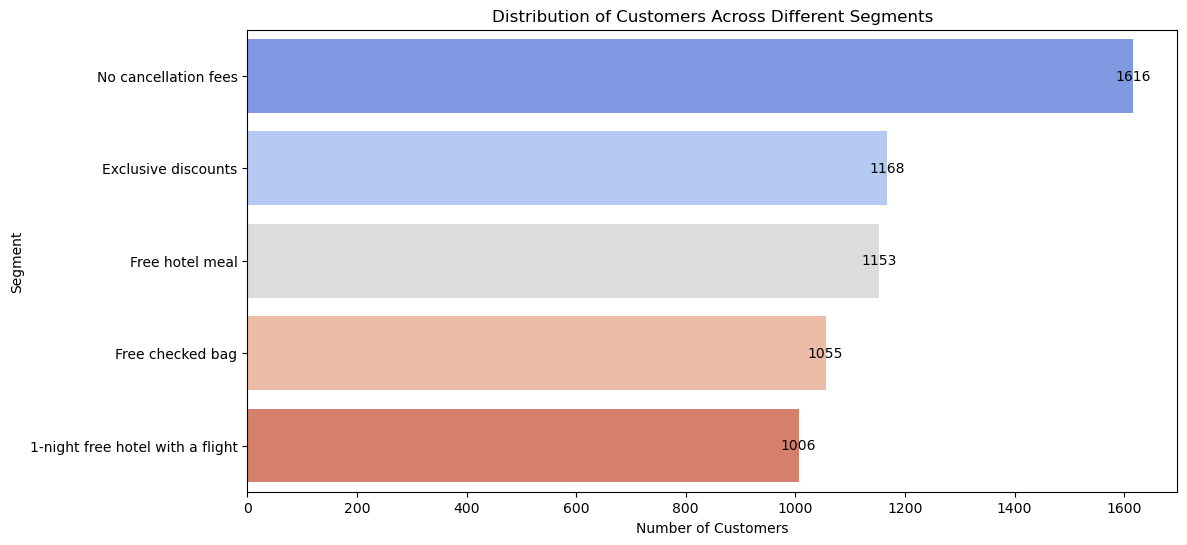

In [65]:
# Count the number of customers in each segment
segment_count = cohort_users['segment_label'].value_counts().reset_index()
segment_count.columns = ['Segment', 'Number of Customers']

# Plotting the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of Customers', y='Segment', data=segment_count, palette='coolwarm')
plt.title('Distribution of Customers Across Different Segments')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')

# Annotate bars with count values
for index, value in enumerate(segment_count['Number of Customers']):
    plt.text(value, index, str(value), ha='center', va='center', fontsize=10, color='black')

#plt.tight_layout()
plt.show()


## Distribution of perk index values for different perks:

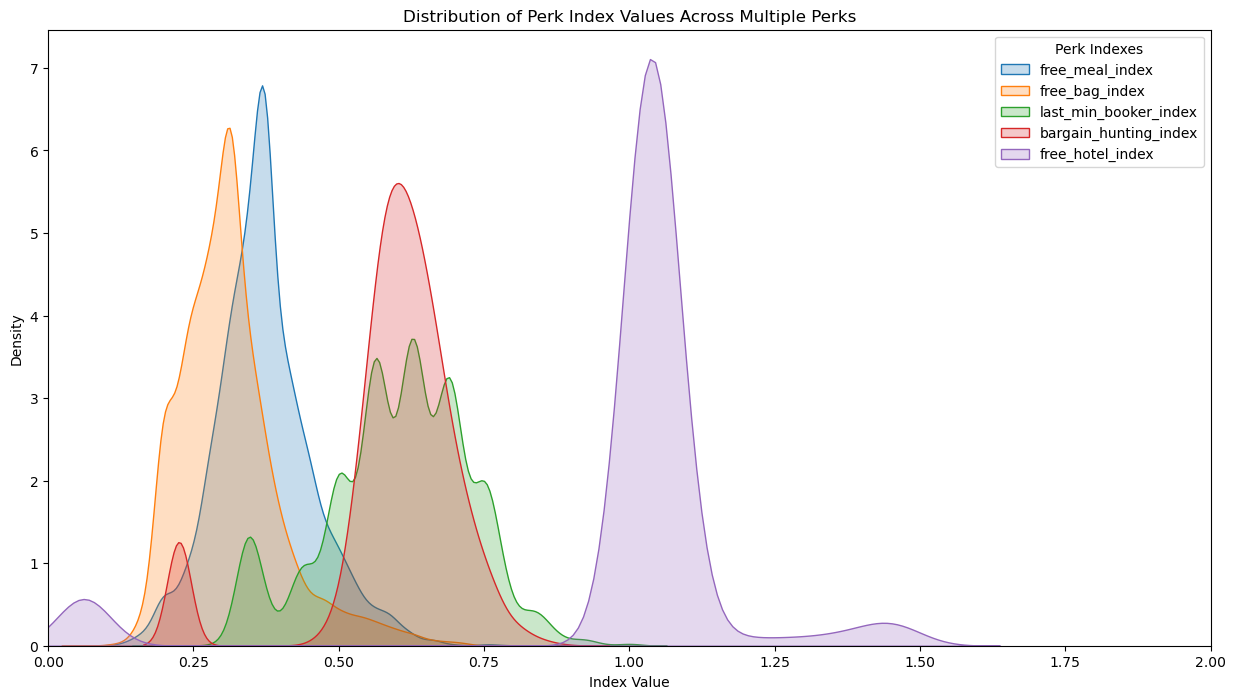

In [66]:
# Filtering only the columns that contain the indexes
index_columns = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 'bargain_hunting_index', 'free_hotel_index']

# Select only the index columns
index_data = cohort_users[index_columns]

# Plotting the distribution of index values for each user
plt.figure(figsize=(15, 8))

# Loop through the columns to plot each one
for column in index_columns:
    sns.kdeplot(index_data[column], label=column, shade=True)

plt.xlim(0, 2)
plt.title('Distribution of Perk Index Values Across Multiple Perks')
plt.xlabel('Index Value')
plt.ylabel('Density')
plt.legend(title='Perk Indexes')
plt.show()

In [67]:
min_value = cohort_users['gender'].min()
max_value = cohort_users['gender'].max()
scaled_values = cohort_users['gender']  
recovered_gender = (scaled_values * (max_value - min_value)) + min_value
cohort_users['gender'] = recovered_gender.astype(int)
cohort_users['gender']

0       0
1       0
2       0
3       0
4       0
       ..
5993    0
5994    0
5995    0
5996    0
5997    0
Name: gender, Length: 5998, dtype: int64

In [68]:
# Gender analysis: drawing the countplot for gender distribution across different perks using
plt.figure(figsize=(12, 6))
sns.countplot(data=cohort_users, x='segment_label', hue='gender', palette="deep")

plt.title('Gender Distribution by Perk')
plt.ylabel('Number of Customers')
plt.xticks(rotation=15)
plt.show()